## Soumil Nitin Shah 
Bachelor in Electronic Engineering |
Masters in Electrical Engineering | 
Master in Computer Engineering |

* Website : http://soumilshah.com/
* Github: https://github.com/soumilshah1995
* Linkedin: https://www.linkedin.com/in/shah-soumil/
* Blog: https://soumilshah1995.blogspot.com/
* Youtube : https://www.youtube.com/channel/UC_eOodxvwS_H7x2uLQa-svw?view_as=subscriber
* Facebook Page : https://www.facebook.com/soumilshah1995/
* Email : shahsoumil519@gmail.com
* projects : https://soumilshah.herokuapp.com/project

* I earned a Bachelor of Science in Electronic Engineering and a double master’s in Electrical and Computer Engineering. I have extensive expertise in developing scalable and high-performance software applications in Python. I have a YouTube channel where I teach people about Data Science, Machine learning, Elastic search, and AWS. I work as data Team Lead at Jobtarget where I spent most of my time developing Ingestion Framework and creating microservices and scalable architecture on AWS. I have worked with a massive amount of data which includes creating data lakes (1.2T) optimizing data lakes query by creating a partition and using the right file format and compression. I have also developed and worked on a streaming application for ingesting real-time streams data via kinesis and firehose to elastic search



# Change-Data-Capture (CDC)

#### The Change-Data-Capture (CDC) feature enables Hudi to show how records were changed by producing the changes and therefore to handle CDC query usecases.

* In cases where Hudi tables used as streaming sources, we want to be aware of all records' changes in one commit exactly, as in which records were inserted, deleted, and updated. And for updated records, the old values before update and the new ones after.


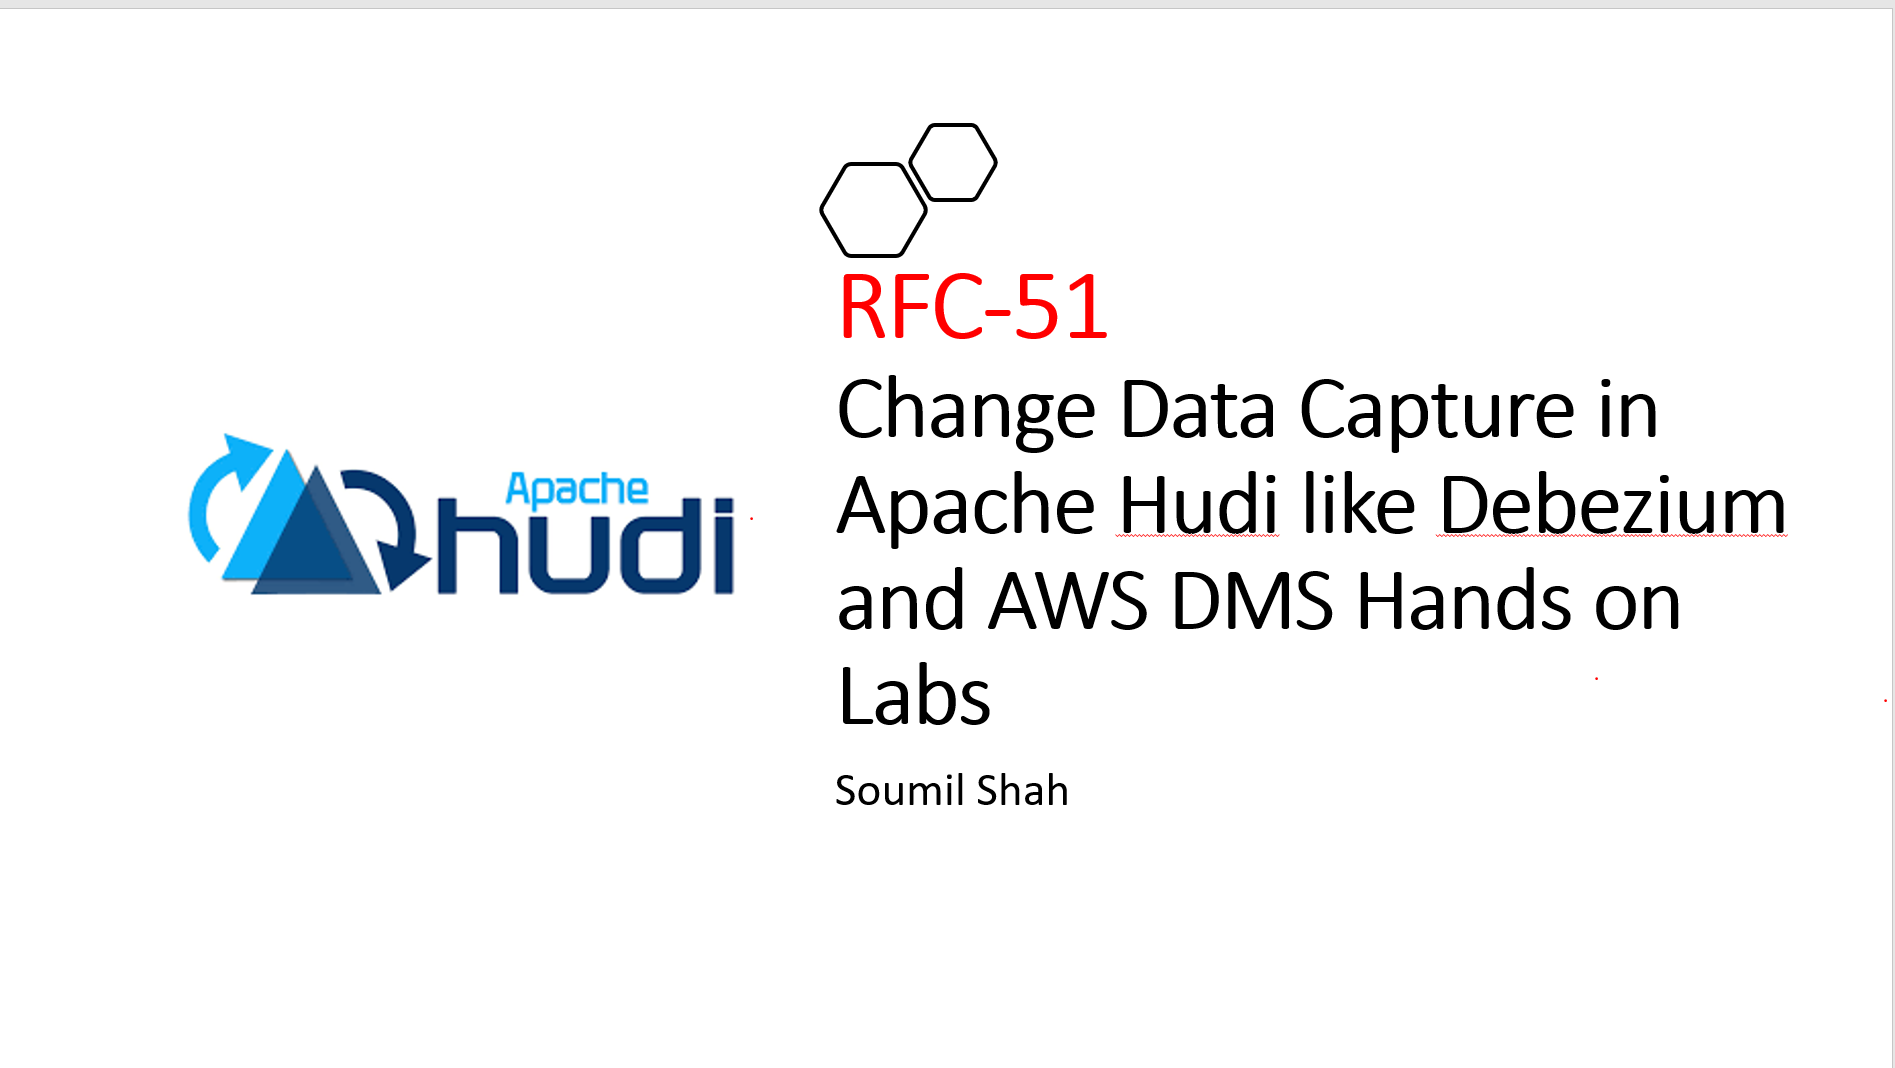

# Step 1: Define Imports 

In [1]:
try:

    import os
    import sys
    import uuid

    import pyspark
    from pyspark.sql import SparkSession
    from pyspark import SparkConf, SparkContext
    from pyspark.sql.functions import col, asc, desc
    from pyspark.sql.functions import col, to_timestamp, monotonically_increasing_id, to_date, when
    from pyspark.sql.functions import *
    from pyspark.sql.types import *
    from datetime import datetime
    from functools import reduce
    from faker import Faker


except Exception as e:
    pass

# Step 2: Create Spark Session

In [2]:
SUBMIT_ARGS = "--packages org.apache.hudi:hudi-spark3.3-bundle_2.12:0.13.0 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('className', 'org.apache.hudi') \
    .config('spark.sql.hive.convertMetastoreParquet', 'false') \
    .getOrCreate()
spark


# Step 3: Define Settings for Hudi CDC tables 

In [75]:
db_name = "hudidb"
table_name = "hudi_cdc_table"

recordkey = 'uuid'
path = f"file:///C:/tmp/{db_name}/{table_name}"
precombine = "date"
method = 'upsert'
table_type = "COPY_ON_WRITE"  # COPY_ON_WRITE | MERGE_ON_READ

hudi_options = {
    'hoodie.table.name': table_name,
    'hoodie.datasource.write.recordkey.field': recordkey,
    'hoodie.datasource.write.table.name': table_name,
    'hoodie.datasource.write.operation': method,
    'hoodie.datasource.write.precombine.field': precombine,
    'hoodie.table.cdc.enabled':'true',
    'hoodie.table.cdc.supplemental.logging.mode': 'data_before_after',
    
}

# Step 4: performing inserts updates and deletes on datalake 

#### INSERTS 

In [76]:
spark_df = spark.createDataFrame(
    data=[
    (1, "insert 1",  111,  "2020-01-06 12:12:12"),
    (2, "insert 2",  22, "2020-01-06 12:12:12"),
], 
    schema=["uuid", "message", "precomb", "date"])

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

#### Updates

In [77]:
spark_df = spark.createDataFrame(
    data=[
    (1, "update 1",  111,  "2020-01-06 12:12:12"),
], 
    schema=["uuid", "message", "precomb", "date"])

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

# Query the Transcational Datalake with CDC and Incremental Query

In [78]:
df = spark. \
      read. \
      format("hudi"). \
      load(path)
df.select("_hoodie_commit_time").show()

+-------------------+
|_hoodie_commit_time|
+-------------------+
|  20230225085226729|
|  20230225085157934|
+-------------------+



In [79]:
spark. \
      read. \
      format("hudi"). \
      load(path). \
      createOrReplaceTempView("hudi_snapshot")

commits = list(map(lambda row: row[0], spark.sql("select distinct(_hoodie_commit_time) as commitTime from  hudi_snapshot order by commitTime").limit(50).collect()))
beginTime = commits[len(commits) - 2] # commit time we are interested in
beginTime = int(beginTime) - 1

print(f"commits : {commits} beginTime : {beginTime} \n")
print("beginTime", beginTime, end="\n")
print("\n")

incremental_read_options = {
    'hoodie.datasource.query.type': 'incremental',
    'hoodie.datasource.query.incremental.format':'cdc',
    'hoodie.datasource.read.begin.instanttime': beginTime,

}

IncrementalDF = spark.read.format("hudi"). \
  options(**incremental_read_options). \
  load(path)

IncrementalDF.createOrReplaceTempView("hudi_incremental")
df_test = spark.sql("select * from  hudi_incremental" )

df_test.printSchema()

df_test.show()

df_test.filter(df_test.op == 'u').select("before").show(truncate=False)

df_test.filter(df_test.op == 'u').select("after").show(truncate=False)

commits : ['20230225085157934', '20230225085226729'] beginTime : 20230225085157933 

beginTime 20230225085157933


root
 |-- op: string (nullable = true)
 |-- ts_ms: string (nullable = true)
 |-- before: string (nullable = true)
 |-- after: string (nullable = true)

+---+-----------------+--------------------+--------------------+
| op|            ts_ms|              before|               after|
+---+-----------------+--------------------+--------------------+
|  i|20230225085157934|                null|{"date":"2020-01-...|
|  i|20230225085157934|                null|{"date":"2020-01-...|
|  u|20230225085226729|{"uuid": 1, "mess...|{"uuid": 1, "mess...|
+---+-----------------+--------------------+--------------------+

+---------------------------------------------------------------------------------+
|before                                                                           |
+---------------------------------------------------------------------------------+
|{"uuid": 1, "mess

# References 
* https://github.com/apache/hudi/blob/master/rfc/rfc-51/rfc-51.md
* Special thanks to Hans Eschbaum for help :D 
